In [1]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import cufflinks as cf
import plotly
import datetime
import math
import matplotlib
import sklearn
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Print versions of libraries
print(f"Numpy version : Numpy {np.__version__}")
print(f"Pandas version : Pandas {pd.__version__}")
print(f"Matplotlib version : Matplotlib {matplotlib.__version__}")
print(f"Seaborn version : Seaborn {sns.__version__}")
print(f"SkLearn version : SkLearn {sklearn.__version__}")
# print(f"Cufflinks version : cufflinks {cf.__version__}")
print(f"Plotly version : plotly {plotly.__version__}")

# Magic Functions for In-Notebook Display
%matplotlib inline

# Setting seabon style
sns.set(style='darkgrid', palette='colorblind')

Numpy version : Numpy 1.23.5
Pandas version : Pandas 1.5.3
Matplotlib version : Matplotlib 3.7.0
Seaborn version : Seaborn 0.12.2
SkLearn version : SkLearn 1.2.1
Plotly version : plotly 5.13.0


In [2]:
seed = 42
accuracy = 'average_precision' # equals to area under recall precision curve
lr_max_iterations = 10000 # increased max_iter to allow lbfgs-solver converging
results = []

In [3]:
df = pd.read_parquet("/home/onyxia/work/df_cct_final.parquet")

In [4]:
import random
random.seed(42)
df_fraud = df[df["Is Fraud?"] == 1]
df_not_fraud = df[df["Is Fraud?"] == 0]
df_fraud_list = df_fraud.index.tolist()
df_not_fraud_list = df_not_fraud.index.tolist()

df_fraud_rs_index = random.sample(df_fraud_list, int(len(df_fraud_list)*0.1))
df_fraud_rs = df_fraud.loc[df_fraud_rs_index]
df_not_fraud_rs_index = random.sample(df_not_fraud_list, int(len(df_not_fraud_list)*0.1))
df_not_fraud_rs = df_not_fraud.loc[df_not_fraud_rs_index]
df = pd.concat([df_not_fraud_rs,df_fraud_rs], axis=0).reset_index(drop=True)

In [5]:
from sklearn.preprocessing import OneHotEncoder

# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df = pd.concat([df, pd.DataFrame(features_array, columns = features_labels)], axis = 1)
# Pour "day_of_week" : 

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df[["day_of_week"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df = pd.concat([df, pd.DataFrame(features_array, columns = features_labels)], axis = 1)
# Pour "Card Brand" : 

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df = pd.concat([df, pd.DataFrame(features_array, columns = features_labels)], axis = 1)
# Pour "Card Type" : 

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df = pd.concat([df, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

selection = ['Card', 'Year', 'Month', 'Day', 'Hours', 'Amount',
       'Credit Limit', 'Year PIN last Changed',
       'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_weekly_declines_card',
       'nb_monthly_declines_card', 'bad_pin', 'insufficient_balance',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'Card Brand_Amex', 'Card Brand_Discover', 'Card Brand_Mastercard',
       'Card Brand_Visa', 'Card Type_Credit', 'Card Type_Debit',
       'Card Type_Debit (Prepaid)', 'Is Fraud?']

estimators = ['Card', 'Year', 'Month', 'Day', 'Hours', 'Amount',
       'Credit Limit', 'Year PIN last Changed',
       'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_weekly_declines_card',
       'nb_monthly_declines_card', 'bad_pin', 'insufficient_balance',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'Card Brand_Amex', 'Card Brand_Discover', 'Card Brand_Mastercard',
       'Card Brand_Visa', 'Card Type_Credit', 'Card Type_Debit',
       'Card Type_Debit (Prepaid)']
df = df[selection]
#df_selec = df_selec[np.isfinite(df_selec).all(1)]



In [6]:
from sklearn.model_selection import train_test_split

X_orig = df.drop('Is Fraud?', axis=1)
y_orig = df["Is Fraud?"]

X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.3,
                                                    random_state=seed, stratify=y_orig)
test_data = [X_test, y_test]

In [7]:
print(f"Training data class counts:\n{y_train.value_counts()}")
print('')
print(f"Test data class counts:\n{y_test.value_counts()}")
print('')
assert(y_test.shape[0]/y_orig.shape[0] > 0.19)

Training data class counts:
0    1705000
1       2082
Name: Is Fraud?, dtype: int64

Test data class counts:
0    730714
1       893
Name: Is Fraud?, dtype: int64



In [8]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [9]:
preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('std', RobustScaler(), ['Card', 'Year', 'Month', 'Day', 'Hours', 'Amount',
       'Credit Limit', 'Year PIN last Changed',
       'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'daily_amount',
       'nb_daily_declines_card', 'nb_weekly_declines_card',
       'nb_monthly_declines_card',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt']), 
        ])

## Model Baseline with class weight

In [50]:
model = Pipeline(steps = [('pr', preprocessor), ('lr', LogisticRegression(class_weight = "balanced", C = 100, penalty = 'l2', random_state=seed))])
model.fit(X_train,y_train)

Pipeline(steps=[('pr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', RobustScaler(),
                                                  ['Card', 'Year', 'Month',
                                                   'Day', 'Hours', 'Amount',
                                                   'Credit Limit',
                                                   'Year PIN last Changed',
                                                   'delta_t_s',
                                                   'delta_t_s_card',
                                                   'amt/daily_income',
                                                   'daily_amount',
                                                   'nb_daily_declines_card',
                                                   'nb_weekly_declines_card',
                                                   'nb_monthly_declines_card',
                                                   'hr_nbt/last_30d_av_hr_nbt',
                                                   'day_nbt/last_30d_av_day_nbt',
                                                   'last_3d_amt/nbt'])])),
                ('lr',
                 LogisticRegression(C=100, class_weight='balanced',
                                    random_state=42))])

In [51]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
cnf_matrix

              precision    recall  f1-score   support

           0       1.00      0.82      0.90    730714
           1       0.00      0.76      0.01       893

    accuracy                           0.82    731607
   macro avg       0.50      0.79      0.45    731607
weighted avg       1.00      0.82      0.90    731607



array([[596041, 134673],
       [   218,    675]])

### GridSearchCV

In [45]:
from sklearn.preprocessing import RobustScaler

# Creating function for scaling
def Robust_Scaler (df, col_names):
    features = df[col_names]
    scaler = RobustScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df
col_names = ['Card', 'Year', 'Month', 'Day', 'Hours', 'Amount',
       'Credit Limit', 'Year PIN last Changed',
       'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'daily_amount',
       'nb_daily_declines_card', 'nb_weekly_declines_card',
       'nb_monthly_declines_card',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt']
X_train = Robust_Scaler (X_train, col_names)
X_test = Robust_Scaler (X_test, col_names)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

LR_model= LogisticRegression(class_weight = "balanced", random_state=seed)

tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] ,
              'penalty':['l1','l2']
                   }

In [47]:
from sklearn.model_selection import GridSearchCV

LR = GridSearchCV(LR_model, tuned_parameters,cv=10, scoring = "f1")
LR.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             scoring='f1')

In [48]:
print('Best parameters:', LR.best_params_)
print('Best score:', LR.best_score_)

Best parameters: {'C': 100, 'penalty': 'l2'}
Best score: 0.010697283360763678


## Oversampling (SMOTE)

In [11]:
!pip install imblearn
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler

In [39]:
oversampler = SMOTE(sampling_strategy='minority', n_jobs=-1, random_state=seed, k_neighbors = 2)
log_reg_os  = LogisticRegressionCV(Cs=5, scoring='f1', max_iter=lr_max_iterations, n_jobs=-1, random_state=seed)


In [40]:
model_smote = imbPipeline([
    ('sampler', oversampler),
    ('pr', preprocessor), 
    ('estimator', log_reg_os)])

model_smote.fit(X_train, y_train)

Pipeline(steps=[('sampler',
                 SMOTE(k_neighbors=2, n_jobs=-1, random_state=42,
                       sampling_strategy='minority')),
                ('pr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', RobustScaler(),
                                                  ['Card', 'Year', 'Month',
                                                   'Day', 'Hours', 'Amount',
                                                   'Credit Limit',
                                                   'Year PIN last Changed',
                                                   'delta_t_s',
                                                   'delta_t_s_card',
                                                   'amt/daily_income',
                                                   'daily_amount',
                                                   'nb_daily_declines_card',
                                                   'nb_weekly_declines_card',
                                                   'nb_monthly_declines_card',
                                                   'hr_nbt/last_30d_av_hr_nbt',
                                                   'day_nbt/last_30d_av_day_nbt',
                                                   'last_3d_amt/nbt'])])),
                ('estimator',
                 LogisticRegressionCV(Cs=5, max_iter=10000, n_jobs=-1,
                                      random_state=42, scoring='f1'))])

In [42]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y_pred_smote = model_smote.predict(X_test)
print(metrics.classification_report(y_test, y_pred_smote))
cnf_matrix_smote = metrics.confusion_matrix(y_test,y_pred_smote)
cnf_matrix_smote

              precision    recall  f1-score   support

           0       1.00      0.84      0.92    730714
           1       0.01      0.71      0.01       893

    accuracy                           0.84    731607
   macro avg       0.50      0.78      0.46    731607
weighted avg       1.00      0.84      0.91    731607



array([[616846, 113868],
       [   257,    636]])

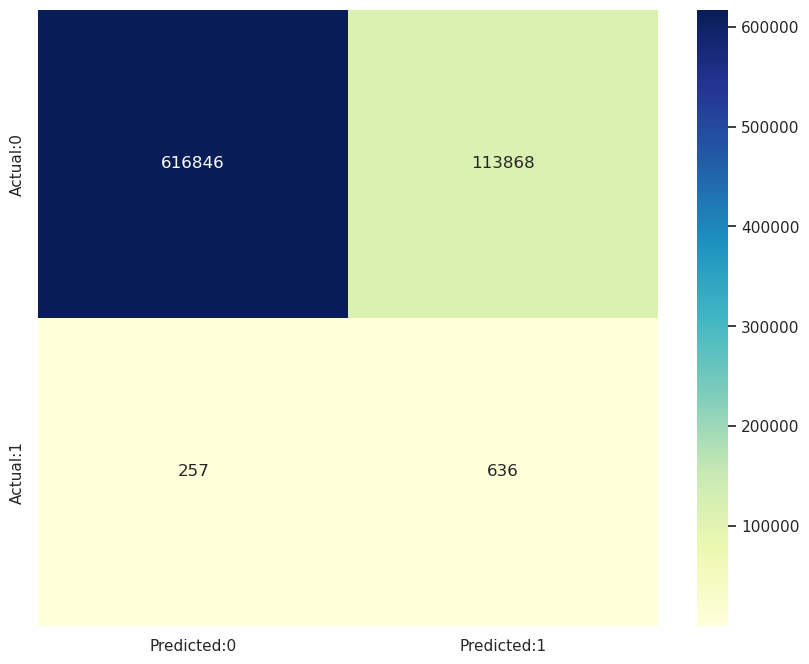

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_smote)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

## Undersampling

In [44]:
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
log_reg_us   = LogisticRegressionCV(Cs=100, scoring='f1',max_iter=lr_max_iterations, n_jobs=-1, random_state=seed)

model_us = imbPipeline([
        ('sampler', undersampler),
        ('pr', preprocessor),
        ('estimator', log_reg_us)])
model_us.fit(X_train, y_train)

Pipeline(steps=[('sampler',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('pr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', RobustScaler(),
                                                  ['Card', 'Year', 'Month',
                                                   'Day', 'Hours', 'Amount',
                                                   'Credit Limit',
                                                   'Year PIN last Changed',
                                                   'delta_t_s',
                                                   'delta_t_s_card',
                                                   'amt/daily_income',
                                                   'daily_amount',
                                                   'nb_daily_declines_card',
                                                   'nb_weekly_declines_card',
                                                   'nb_monthly_declines_card',
                                                   'hr_nbt/last_30d_av_hr_nbt',
                                                   'day_nbt/last_30d_av_day_nbt',
                                                   'last_3d_amt/nbt'])])),
                ('estimator',
                 LogisticRegressionCV(Cs=100, max_iter=10000, n_jobs=-1,
                                      random_state=42, scoring='f1'))])

In [45]:
from sklearn import metrics 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_pred_us = model_us.predict(X_test)
print(metrics.classification_report(y_test, y_pred_us))
cnf_matrix_us = metrics.confusion_matrix(y_test,y_pred_us)
cnf_matrix_us

              precision    recall  f1-score   support

           0       1.00      0.83      0.91    730714
           1       0.01      0.75      0.01       893

    accuracy                           0.83    731607
   macro avg       0.50      0.79      0.46    731607
weighted avg       1.00      0.83      0.91    731607



array([[608279, 122435],
       [   222,    671]])

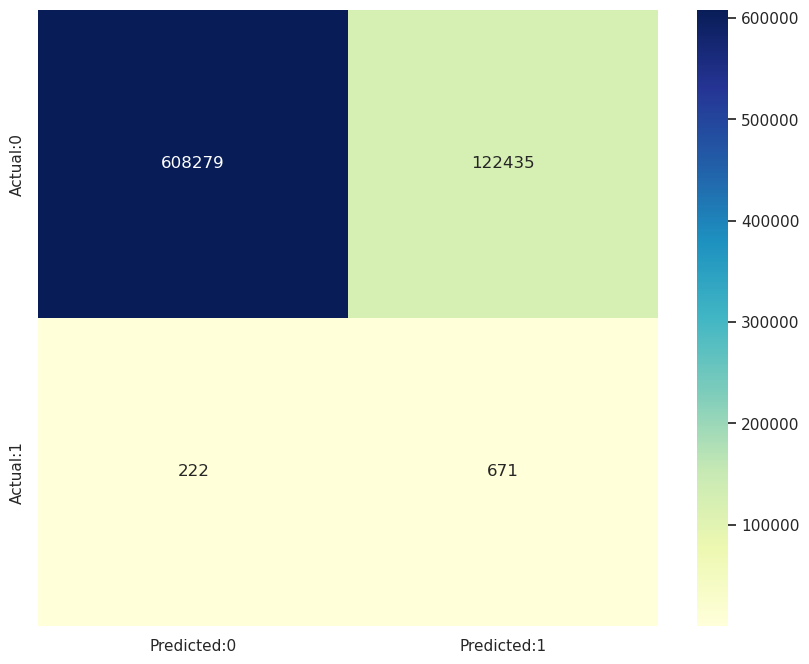

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_us)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

## Combined Sampling

In [47]:
combined_sampler = SMOTETomek(n_jobs=-1, random_state=seed)
log_reg_comb   = LogisticRegressionCV(Cs=100, scoring='f1', max_iter=lr_max_iterations, n_jobs=-1, random_state=seed)

model_comb = imbPipeline([
        ('sampler', combined_sampler),
        ('pr', preprocessor),
        ('estimator', log_reg_comb)])

model_comb.fit(X_train, y_train)


Pipeline(steps=[('sampler', SMOTETomek(n_jobs=-1, random_state=42)),
                ('pr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', RobustScaler(),
                                                  ['Card', 'Year', 'Month',
                                                   'Day', 'Hours', 'Amount',
                                                   'Credit Limit',
                                                   'Year PIN last Changed',
                                                   'delta_t_s',
                                                   'delta_t_s_card',
                                                   'amt/daily_income',
                                                   'daily_amount',
                                                   'nb_daily_declines_card',
                                                   'nb_weekly_declines_card',
                                                   'nb_monthly_declines_card',
                                                   'hr_nbt/last_30d_av_hr_nbt',
                                                   'day_nbt/last_30d_av_day_nbt',
                                                   'last_3d_amt/nbt'])])),
                ('estimator',
                 LogisticRegressionCV(Cs=100, max_iter=10000, n_jobs=-1,
                                      random_state=42, scoring='f1'))])

In [48]:
y_pred_comb = model_comb.predict(X_test)
print(metrics.classification_report(y_test, y_pred_comb))
cnf_matrix_comb = metrics.confusion_matrix(y_test,y_pred_comb)
cnf_matrix_comb

              precision    recall  f1-score   support

           0       1.00      0.84      0.92    730714
           1       0.01      0.71      0.01       893

    accuracy                           0.84    731607
   macro avg       0.50      0.78      0.46    731607
weighted avg       1.00      0.84      0.91    731607



array([[616472, 114242],
       [   259,    634]])

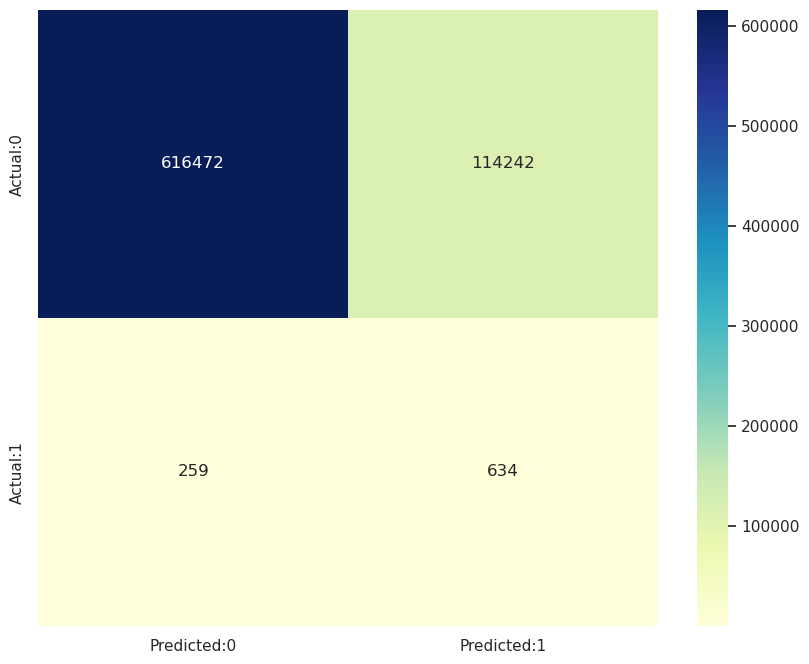

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_comb)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
print(roc_auc_score(y_test,y_pred_comb))

0.7768117156214949


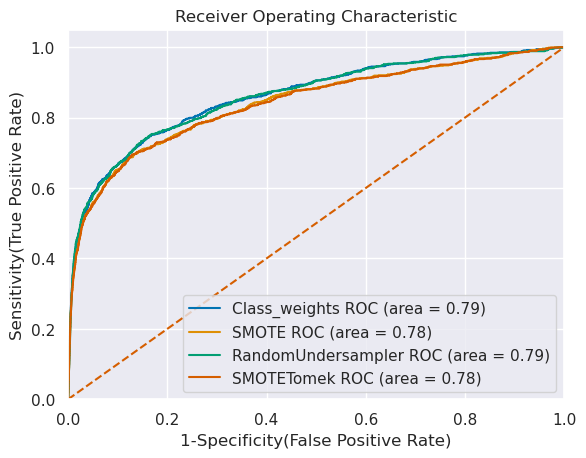

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Class_weights',
    'model': model,
},
{
    'label': 'SMOTE',
    'model': model_smote,
},
{
    'label': 'RandomUndersampler',
    'model': model_us,
},
{
    'label': 'SMOTETomek',
    'model': model_comb,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Credit card fraud detection')
plt.legend(loc="lower right")
plt.show()   # Display